# Notebook **Four** - Creating fiducial redshift tables from tool & literature identified spectroscopic redshifts

## Import statements and reading history/sample

In [1]:
from ident_run_setup import cosmo, side_length, HISTORY_FILE_PATH, load_history, proj_name, update_history

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
import json
import os
from warnings import warn

%matplotlib inline

In [2]:
cur_history = load_history()

Made a mistake in an earlier version of the spectral identification class, and the 6dF observation spectrum ID was just called 'spec_id' in the history, which clashes with some other headers when I'm constructing the multi-index dataframe below:

In [3]:
spec_ident = str(cur_history['bcg_spec_identification'])
if "'survey_spec_id': {'spec_id'" in spec_ident:
    spec_ident = spec_ident.replace("'survey_spec_id': {'spec_id'", "'survey_spec_id': {'obs_spec_id'")
    spec_ident = eval(spec_ident)
    cur_history['bcg_spec_identification'] = spec_ident
    update_history(cur_history)

In [4]:
samp = pd.read_csv(cur_history['static_samp_file'])
# This means we can use .loc[ENTER NAME HERE] to get the information for a particular cluster
samp = samp.set_index('name')

# This method shows the top two lines of the loaded-in sample file
samp.head(2)

,LoVoCCSID,common_name,cent_im_ra,cent_im_dec,redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,MCXC_Lx500_0.1_2.4,ang_prop_ratio
name,,,,,,,,,,,,
LoVoCCS-1,1,A2029,227.7343,5.745471,0.0766,1.3344,227.73,5.72,227.7343,5.745471,8.726709e+44,86.035164
LoVoCCS-2,2,A401,44.7400,13.580000,0.0739,1.2421,44.74,13.58,NaN,NaN,6.088643e+44,83.258258


## Reading the identified BCG sample file

In [5]:
bcg_samp = pd.read_csv("outputs/bcg_output_sample.csv")
bcg_samp

,cluster_name,no_bcg_cand,BCG1_desi-ls_ra,BCG1_desi-ls_dec,BCG2_desi-ls_ra,BCG2_desi-ls_dec,BCG3_desi-ls_ra,BCG3_desi-ls_dec,BCG4_desi-ls_ra,BCG4_desi-ls_dec,BCG1_lovoccs_ra,BCG1_lovoccs_dec,BCG2_lovoccs_ra,BCG2_lovoccs_dec
0,LoVoCCS-1,False,227.733824,5.744883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LoVoCCS-2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.740836,13.582646,NaN,NaN
2,LoVoCCS-4A,False,10.460194,-9.302871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-4B,False,10.429048,-9.439317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-5,False,303.113338,-56.826500,302.710346,-56.673695,303.506670,-57.027568,303.49407,-57.039226,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,LoVoCCS-121,False,52.460588,-52.579591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,LoVoCCS-122,False,156.994404,-6.798922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,LoVoCCS-123,False,193.671028,-29.227460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,LoVoCCS-131,False,137.649589,-10.582130,137.741475,-10.564283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Putting the tool-identified spectroscopic redshifts into a Pandas dataframe

In [6]:
bcg_spec_rejig = [{'name': clust_name} | spec_info for clust_name, spec_info in cur_history['bcg_spec_identification'].items()]
spec_info = pd.json_normalize(bcg_spec_rejig)

rel_cols = spec_info.columns[(spec_info.columns == 'name') | spec_info.columns.str.contains(r'\.spec_id|z') | 
                              spec_info.columns.str.endswith('survey') | spec_info.columns.str.endswith('ra') | 
                              spec_info.columns.str.endswith('dec')]
spec_info = spec_info[rel_cols]
spec_info = spec_info.set_index('name')

spec_info.columns = pd.MultiIndex.from_tuples([tuple(col.split(".")) for col in spec_info.columns])
spec_info = spec_info.droplevel(1, axis=1)
spec_info.sort_index(axis=1, inplace=True)

In [7]:
spec_info

BCG1                                                    \
                 spec0                                                     
                   dec          ra    spec_id survey         z     z_err   
name                                                                       
LoVoCCS-1     5.741376  227.733109  4634042.0    cfa  0.073284  0.000667   
LoVoCCS-2    13.582242   44.741482  4611177.0    cfa  0.074518  0.000500   
LoVoCCS-4A   -9.303146   10.460272   231472.0   sdss  0.055359  0.000016   
LoVoCCS-4B   -9.439230   10.428671  4605284.0    cfa  0.056326  0.000117   
LoVoCCS-5   -56.824081  303.113892  4639181.0    cfa  0.055378  0.000147   
...                ...         ...        ...    ...       ...       ...   
LoVoCCS-121 -52.579910   52.461823  4612420.0    cfa  0.063944  0.000334   
LoVoCCS-122  -6.798972  156.994542  4493134.0    6df  0.116297       NaN   
LoVoCCS-123        NaN         NaN        NaN    NaN       NaN       NaN   
LoVoCCS-131        NaN         NaN        NaN    NaN       NaN       NaN   
LoVoCCS-134        NaN         NaN        NaN    NaN       NaN       NaN   

                                                                               \
                          spec1                                                 
            z_quality       dec          ra       spec_id    survey         z   
name                                                                            
LoVoCCS-1         NaN  5.744990  227.733917  4.634043e+06       cfa  0.077997   
LoVoCCS-2         NaN       NaN         NaN           NaN       NaN       NaN   
LoVoCCS-4A        NaN -9.303424   10.460848  4.605303e+06       cfa  0.055158   
LoVoCCS-4B        NaN -9.439417   10.429209  5.683825e+06      fast  0.056123   
LoVoCCS-5         NaN       NaN         NaN           NaN       NaN       NaN   
...               ...       ...         ...           ...       ...       ...   
LoVoCCS-121       NaN       NaN         NaN           NaN       NaN       NaN   
LoVoCCS-122       4.0 -6.798959  156.994565  2.842364e+15  desi_dr1  0.116045   
LoVoCCS-123       NaN       NaN         NaN           NaN       NaN       NaN   
LoVoCCS-131       NaN       NaN         NaN           NaN       NaN       NaN   
LoVoCCS-134       NaN       NaN         NaN           NaN       NaN       NaN   

                                                                             \
                                    spec2                                     
                z_err z_quality       dec          ra    spec_id     survey   
name                                                                          
LoVoCCS-1    0.000334       NaN  5.741509  227.733208  4712886.0  hectospec   
LoVoCCS-2         NaN       NaN       NaN         NaN        NaN        NaN   
LoVoCCS-4A   0.000147       NaN -9.305278   10.459291  5673213.0       fast   
LoVoCCS-4B        NaN       NaN -9.439417   10.429292  5686980.0       fast   
LoVoCCS-5         NaN       NaN       NaN         NaN        NaN        NaN   
...               ...       ...       ...         ...        ...        ...   
LoVoCCS-121       NaN       NaN       NaN         NaN        NaN        NaN   
LoVoCCS-122  0.000018       NaN       NaN         NaN        NaN        NaN   
LoVoCCS-123       NaN       NaN       NaN         NaN        NaN        NaN   
LoVoCCS-131       NaN       NaN       NaN         NaN        NaN        NaN   
LoVoCCS-134       NaN       NaN       NaN         NaN        NaN        NaN   

                                                                               \
                                          spec3                                 
                    z z_err z_quality       dec          ra    spec_id survey   
name                                                                            
LoVoCCS-1    0.073512   NaN       NaN  5.744722  227.733749  5678635.0   fast   
LoVoCCS-2         NaN   NaN       NaN       NaN         NaN        NaN

## Selecting **one** tool-identified redshift per candidate

In [8]:
all_survey = np.unique(spec_info.loc(axis=1)[:, :, 'survey'].values.astype(str))
all_survey

array(['2df', '2dflens', '6df', 'cfa', 'desi_dr1', 'eboss', 'fast',
       'hectospec', 'lamost', 'nan', 'sdss', 'uzc', 'wigglez'],
      dtype='<U9')

Ranking reasons:
1) SDSS, eBOSS, and DESI are in that order because the SDSS/eBOSS archive is very mature, and though DESI has a higher spectral resolution the first data release is only a few months old (at the time of writing).
2) LAMOST has a higher spectral resolution than the other options (R~1800).
3) HECTOSpec has an R~1000 - also we believe that it may more often be used for targeted observations, thus potentially having better SNR spectra.
4) Next are 6dF and FAST, both with similar spectral resolutions (FAST R is dependent on the selected grating, which may not be an issue for 6dF given it was a survey).
5) Then 2dF and 2dFlens - here simply because they are older than 6dF.
6) Then CfA, UZC, and WiggleZ because we can't easily access the actual spectra data.

In [9]:
ranking = {'sdss': 0, 'eboss': 1, 'desi_dr1': 2, 'lamost': 3, 'hectospec': 4, '6df': 5, 'fast': 6, '2df': 7, 
           '2dflens': 8, 'cfa': 9, 'uzc': 10, 'wigglez': 11}

Notes on acceptable redshift quality flags:
* SDSS - Null values mean no problems, other flag values have different meanings specified here - https://www.sdss3.org/dr10/algorithms/bitmask_zwarning.php
* 6dF - "Q=4 represents a reliable redshift while Q=3 is assigned to probable redshifts; Q=2 is reserved for tentative redshift values and Q=1 for spectra of no value [https://ui.adsabs.harvard.edu/abs/2004MNRAS.355..747J/abstract]
* 2dF - "Q>=3 redshifts are 98.4% reliable"[https://ui.adsabs.harvard.edu/abs/2001MNRAS.328.1039C/abstract]
* 2dFLens - Might have a slightly different set of flags - https://2dflens.swin.edu.au/data.html - with there being a '6' flag that means it is NOT an extragalactic spectrum.

In [10]:
z_qual_check = {'6df': lambda x: x >= 3, 
                '2df': lambda x: x >= 3, 
                '2dflens': lambda x: (x >= 3) & (x != 6),
                'sdss': lambda x: not isinstance(x, int), 
                'eboss': lambda x: not isinstance(x, int)}

In [11]:
# Gets the candidate labels we will need to iterate through (e.g. BCG1, BCG2, etc.)
all_cand_labels = np.unique(spec_info.columns.get_level_values(0).values)

# Makes sure we know what order the columns will be in for the output dataframe, though there will also be a 'name' on
#  the front to indicate the cluster
col_order = ['spec_id', 'survey', 'ra', 'dec', 'z', 'z_err', 'z_quality', 'ok_z_quality']

# We'll store the output dataframes in this
fid_z_dfs = {}
for cur_cand in all_cand_labels:

    fid_z_cur_cand_info = []
    for row_ind, row in spec_info[cur_cand].iterrows():
        
        # Check if there actually is a candidate
        rel_bcg_samp_row = bcg_samp.iloc[np.argwhere(bcg_samp['cluster_name'] == row.name).flatten()[0]]

        desi_col = "{cc}_desi-ls_ra".format(cc=cur_cand.upper())
        lov_col = "{cc}_lovoccs_ra".format(cc=cur_cand.upper())
        
        if np.isnan(rel_bcg_samp_row[desi_col]) and (lov_col not in rel_bcg_samp_row or np.isnan(rel_bcg_samp_row[lov_col])):
            continue

        # If we get this far we put the name of the cluster as the first entry in the new row
        new_fidz_cur_cand_row_dat = [row.name]
        
        # The call to 'align' makes sure that the boolean slicer dataframe returned by checking the survey isn't NaN, is mapped
        #  such that it can be passed as a slicer to the overall row and just return the spec columns with actual entries in for
        #  this particular BCG
        col_with_spec = row.align(~row.loc[:, 'survey'].isnull(), level=0)[1]
        cut_row = row[col_with_spec]
    
        # We pull out the number of spectra we have for the current BCG candidate
        cur_num_spec = len(cut_row.index.get_level_values(0).unique())
        
        # Nothing to do in this case    
        if cur_num_spec == 0:
            pass
            
        # If there is only one spectrum, we don't have to mess around, we'll use its spec-z as the fiducial value
        elif cur_num_spec == 1:
            # The last 'True' entry is for the 'only_tool_spec' column, indicating that there wasn't a choice of
            #  spectra for the 'fiducial' table we're producing here
            to_add = cut_row['spec0']
            to_add['ok_z_quality'] = z_qual_check[to_add['survey']](to_add['z_quality']) if to_add['survey'] in z_qual_check else np.NaN
            to_add = to_add[col_order].values.tolist() + [True, 'tool']
            new_fidz_cur_cand_row_dat += to_add
            
        # Here there are multiple spectra available
        else:
            # Read out the surveys of all the associated spectra
            cur_spec_survs = cut_row[:, 'survey'].values.astype(str)
            # Read out corresponding Pandas labels to easily read out the chosen spectrum in the end
            cur_spec_labels = cut_row.index.get_level_values(0).unique()
            # Nice to have a set of indexes telling us the same thing to refer back to
            cur_spec_inds = np.arange(0, len(cur_spec_survs))
            
            # These flags aren't set for all surveys in RCSEDv2, but where they do exist they indicate 
            #  the likely reliability of the redshift
            cur_spec_quals = cut_row[:, 'z_quality'].astype('Int64').values
            # Assessing the quality flag assigned to the redshifts (if it exists for the spectrum's survey) - if there is no
            #  quality flag then we set the value to np.NaN (which we will treat as True later, as we have to assume 
            #  it is good enough to use)
            cur_spec_qual_good = np.array([z_qual_check[surv](cur_spec_quals[surv_ind]) 
                                           if surv in z_qual_check else np.NaN for surv_ind, surv in enumerate(cur_spec_survs)])
    
            # Cutting down the spectra to those that have an acceptable redshift quality - if none remain then 
            #  this change will be reverted and a warning will be shown
            # Remember that some surveys have no quality information, and have a NaN entry from our checking whether 
            #  the redshift is okay or not, so we have to allow those with NaN as well
    
            cur_good_z_mask = cur_spec_qual_good.copy()
            cur_good_z_mask[np.isnan(cur_good_z_mask)] = True
            cur_good_z_mask = cur_good_z_mask.astype(bool)
            
            cur_good_spec_labels = cur_spec_labels[cur_good_z_mask]
            cur_good_spec_inds = cur_spec_inds[cur_good_z_mask]
            
            if len(cur_good_spec_labels) == 0:
                warn("All {cl}-{bc} spectra have z quality warnings - we will use one of them, but "
                     "don't put too much weight on it.".format(cl=row.name, bc=cur_cand))
                cur_good_spec_labels = cur_spec_labels
                cur_good_spec_inds = cur_spec_inds
            
            # Fetching the rank of all of the flagged-good associated spectra's surveys
            cur_spec_ranks = np.array([ranking[surv] for surv in cur_spec_survs[cur_good_z_mask]])
            # Lowest number -> best rank
            cur_ind_best_rank = cur_good_spec_inds[np.argmin(cur_spec_ranks)]
            # Name of the survey the highest ranked spectrum is from 
            cur_highest_ranked_surv = cur_spec_survs[cur_ind_best_rank]
            
            # In this case there are multiple spectra from the highest ranked survey associated with
            #  the candidate - we have to try to choose between them
            if (cur_spec_survs[cur_good_z_mask] == cur_highest_ranked_surv).sum() > 1:
                rel_spec_labels = cur_good_spec_labels[cur_spec_survs[cur_good_z_mask] == cur_highest_ranked_surv]
                multi_sel_sp_info = cut_row[rel_spec_labels]
       
                # Checks if any of the potential fiducial spectra have redshift uncertainties - first case
                #  is that there are no redshift uncertainties, in which case we'll just choose the first
                #  one as I don't really know what else to do
                if multi_sel_sp_info[:, 'z_err'].isnull().all():
                    chos_spec_label = rel_spec_labels[0]
                    sel_sp_info = multi_sel_sp_info[chos_spec_label]
                # The other broad case is that at least some of the spectra do have redshift uncertainties
                else:
                    # Here we discount any spectrum that has no uncertainty, as we much prefer ones that do
                    #  have uncertainties if we get the choice
                    spec_with_uncert = (~multi_sel_sp_info[:, 'z_err'].isnull())
                    rel_spec_labels = rel_spec_labels[spec_with_uncert]
                    multi_sel_sp_info = multi_sel_sp_info[rel_spec_labels]
    
                    # Find the entry with the smallest uncertainty
                    min_err_ind = multi_sel_sp_info[:, 'z_err'].argmin()
                    chos_spec_label = rel_spec_labels[min_err_ind]
                    sel_sp_info = multi_sel_sp_info[chos_spec_label]
                    
            # But in this case there one spectrum with the highest rank, no duplicate surveys
            else:
                # Selects the spectrum we're going to use for the fiducial redshift info
                chos_spec_label = cur_spec_labels[cur_ind_best_rank]
                sel_sp_info = cut_row[chos_spec_label]
            
            # Add the quality information, as it is possible we've had to go with a spectrum that didn't actually
            #  pass the quality check
            sel_sp_info['ok_z_quality'] = cur_spec_qual_good[cur_spec_labels == chos_spec_label][0]
    
            # This adds the 'only_tool_spec' column, which indicates whether the selected spectrum was 
            #  the only one found, or if we whittled down a set of spectra to just one, and the 'source'
            #  column which helps to distinguish between tool-selected and literature-selected redshifts
            to_add = sel_sp_info[col_order].values.tolist() + [False, 'tool']
            new_fidz_cur_cand_row_dat += to_add
            
        # Store the newly constructed row with the fiducial information for the current cluster and candidate 
        fid_z_cur_cand_info.append(new_fidz_cur_cand_row_dat)
    
    fiducial_cur_cand_z = pd.DataFrame(fid_z_cur_cand_info, columns=["name"] + col_order + ['only_tool_spec', 'source'])
    # Can't for the life of me figure out how to change the dtype of all the spec_id columns in the multi-index 
    #  Pandas column implementation - so I will change it here
    # , 'ok_z_quality': bool
    fiducial_cur_cand_z = fiducial_cur_cand_z.astype({"spec_id": 'Int64'})
    # Daft way to do this, but I convert the spec_id to an int before string so there is no 
    #  trailing .0 on the spec ids
    fiducial_cur_cand_z = fiducial_cur_cand_z.astype({"spec_id": 'str'})

    # Make sure it is clear that the RA-Dec entries are the spectra's RA and Decs
    fiducial_cur_cand_z = fiducial_cur_cand_z.rename(columns={'ra': 'spec_ra', 'dec': 'spec_dec'})
    
    # Store the current candidate fiducial redshift dataframe in the dictionary we set up earlier
    fid_z_dfs[cur_cand] = fiducial_cur_cand_z

## Adding literature-identified redshifts for candidates without tool-identified spectra

In [12]:
# Gets the candidate labels we will need to iterate through (e.g. BCG1, BCG2, etc.)
all_cand_labels = np.unique(spec_info.columns.get_level_values(0).values)

for cur_cand in all_cand_labels:
    cur_fid_z_df = fid_z_dfs[cur_cand]
    
    cur_lit_specz_pth = "outputs/literature_specz_for_cands_without/{cc}_cand_notoolz_litspecz.json".format(cc=cur_cand.lower())
    with open(cur_lit_specz_pth, 'r') as reado:
        cur_lit_speczs = json.load(reado)

    for name, lit_sp_info in cur_lit_speczs.items():
        rel_ind = np.argwhere(cur_fid_z_df['name'] == name).flatten()[0]
        to_set = [lit_sp_info['unique_id'], lit_sp_info['z'], lit_sp_info['z_err'], lit_sp_info['source']]
        cur_fid_z_df.loc[rel_ind, ['spec_id', 'z', 'z_err', 'source']] = to_set

## Writing the fiducial tables to disk 

In [13]:
tab_dir = "outputs/fiducial_cand_redshift_tables/"
os.makedirs(tab_dir, exist_ok=True)
for cur_cand, cur_fid_z_df in fid_z_dfs.items():
    cur_fid_z_df.to_csv(tab_dir + "{cc}_fiducial_specz.csv".format(cc=cur_cand), index=False)

## Quick visual comparison to original redshifts

In [14]:
comp_fig_dir = tab_dir + "comparison_figures/"
os.makedirs(comp_fig_dir, exist_ok=True)

Now we make the figures:

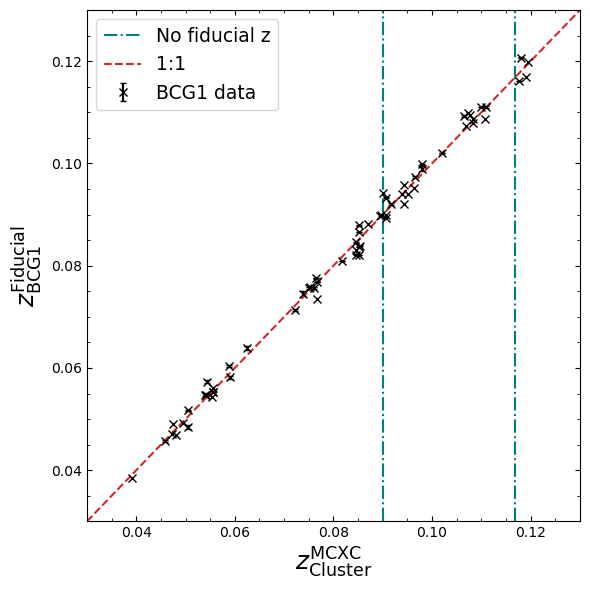

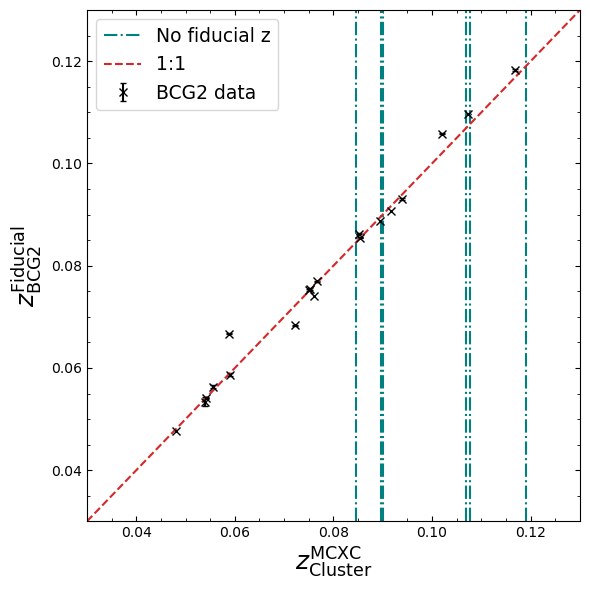

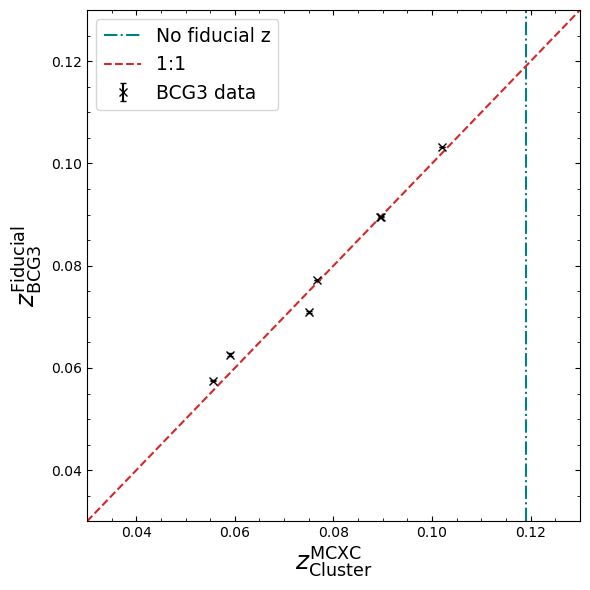

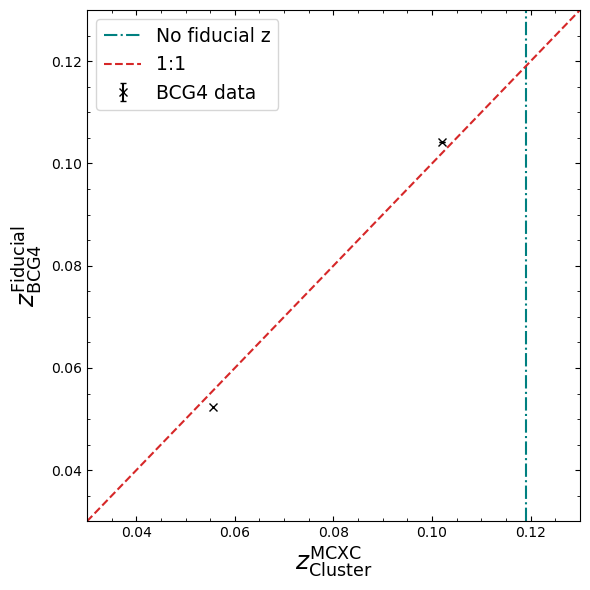

In [15]:
for cur_cand, cur_fid_z_df in fid_z_dfs.items():
    og_zs = samp.loc[cur_fid_z_df['name'], 'redshift'].values

    plt.figure(figsize=(6, 6))
    # plt.title("{cc} candidate redshift comparison".format(cc=cur_cand), fontsize=15)
    plt.minorticks_on()
    plt.tick_params(which='both', direction='in', top=True, right=True)
    
    plt.errorbar(og_zs, cur_fid_z_df['z'].values, yerr=cur_fid_z_df['z_err'].values, fmt='kx', capsize=2, 
                 label="{cc} data".format(cc=cur_cand))

    # Show the MCXC redshifts with no corresponding fiducial redshift as vertical lines
    og_zs_with_no_new_specz = og_zs[np.where(np.isnan(cur_fid_z_df['z'].values))[0]]
    for lonely_og_z_ind, lonely_og_z in enumerate(og_zs_with_no_new_specz):
        if lonely_og_z_ind == 0:
            label = 'No fiducial z'
        else:
            label = None
        plt.axvline(lonely_og_z, color='teal', linestyle='dashdot', label=label)
    
    lims = [0.03, 0.13]

    # For safety - will show a warning if any data points are off of this plot
    if (og_zs < lims[0]).any() or (og_zs > lims[1]).any():
        warn("Some original MCXC redshifts are outside the current limits; {l}-{u}".format(l=lims[0], u=lims[1]))

    if (cur_fid_z_df['z'].values < lims[0]).any() or (cur_fid_z_df['z'].values > lims[1]).any():
        warn("Some original MCXC redshifts are outside the current limits; {l}-{u}".format(l=lims[0], u=lims[1]))
    
    plt.plot(lims, lims, color='tab:red', linestyle='dashed', label='1:1')
    plt.xlim(lims)
    plt.ylim(lims)

    plt.xlabel(r'$z^{\rm{MCXC}}_{\rm{Cluster}}$', fontsize=18)
    plt.ylabel(r'$z^{\rm{Fiducial}}_{\rm{' + cur_cand + '}}$', fontsize=18)
    
    plt.legend(loc='best', fontsize=13.5)
    plt.tight_layout()
    plt.savefig(comp_fig_dir + "{cc}_fiducial_z_vs_mcxc-cluster-z.pdf".format(cc=cur_cand), bbox_inches='tight')
    plt.show()